In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
df = pd.read_csv('alldata_1_for_kaggle.csv', header = None, encoding='latin1')

df.head()


,0,1,2
0,NaN,0,a
1,0.0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,1.0,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,2.0,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,3.0,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [4]:
df = df[[1,2]]

In [5]:
df.head()

,1,2
0,0,a
1,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [6]:
df.columns=['labels','text']

In [7]:
df.head()

,labels,text
0,0,a
1,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [8]:
df.isnull().sum()

labels    0
text      0
dtype: int64

In [9]:
print(len(df))

7571


In [10]:
df = df.sample(4000)

In [11]:
df.sample(10)

,labels,text
4605,Thyroid_Cancer,breast cancer patients especially those with t...
3412,Colon_Cancer,objective cannabinoids are able to reduce tu...
5579,Thyroid_Cancer,Breast cancer is a common malignancy in women ...
4194,Thyroid_Cancer,"""Identification of key differentially expresse..."
1792,Thyroid_Cancer,"""preadipocytes diï¬erentiate into adipocytes D..."
4110,Thyroid_Cancer,Epidemiologic and clinical features of patien...
789,Lung_Cancer,"""This phenomenon which we did not observe in o..."
1585,Thyroid_Cancer,"""Deregulated circular RNAs circRNAs are associ..."
3547,Colon_Cancer,dysregulation of ribosome production can lead ...
6244,Thyroid_Cancer,EFSA for a scientiï¬c opinion on the risks fo...


In [12]:
df['targets'] = df['labels'].astype('category').cat.codes

In [13]:
df.sample(10)

,labels,text,targets
1981,Colon_Cancer,several immunotherapeutic strategies that harn...,0
1592,Thyroid_Cancer,"""pharmacological therapies and treatments targ...",2
5738,Thyroid_Cancer,Creative Commons Attribution License whichperm...,2
3177,Thyroid_Cancer,"""Proteasomes are found in both the cell nucleu...",2
5273,Lung_Cancer,"""The occurrence of PLC is extremely rare in li...",1
4901,Colon_Cancer,""" lymph node staging of ductal adenocarcinoma...",0
6350,Colon_Cancer,""" among eukaryotic anisms alternative splicin...",0
6412,Colon_Cancer,""" deregulated circular rnas circrnas are asso...",0
6365,Colon_Cancer,""" patients who have undergone radical cystect...",0
3014,Colon_Cancer,the development of fungal fruiting bodies from...,0


In [14]:
df['labels'].value_counts()

Thyroid_Cancer    1511
Colon_Cancer      1333
Lung_Cancer       1156
Name: labels, dtype: int64

In [15]:
K = df['targets'].max() + 1
K

3

In [16]:
from sklearn.model_selection import train_test_split

random_seed = 42

df_train, df_test = train_test_split(df, test_size=0.3, random_state=random_seed)

In [17]:
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [18]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found unique words: {V}')

Found unique words: 201984


In [19]:
data_train = pad_sequences(sequences_train)
print(f'Shape of data train tensor: {data_train.shape}')

Shape of data train tensor: (2800, 4392)


In [20]:
data_train

array([[   0,    0,    0, ..., 1713,    5, 1441],
       [   0,    0,    0, ...,  356,  643,   21],
       [   0,    0,    0, ...,  245,  143,  324],
       ...,
       [   0,    0,    0, ...,  108,  301,  359],
       [   0,    0,    0, ...,  729,    2,  137],
       [   0,    0,    0, ..., 1046,    4,    1]])

In [21]:
T = data_train.shape[1]
T

4392

In [22]:
data_test = pad_sequences(sequences_test, maxlen=T)
print(f'Shape of data test tensor: {data_test.shape}')

Shape of data test tensor: (1200, 4392)


In [23]:
D = 30
i = Input(shape=(T,))
x = Embedding(V+ 1 ,D)(i)
x = Conv1D(32,2, strides=1 ,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i,x)

In [24]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)
print('Training the model...')
r = model.fit(
    data_train,
    df_train['targets'],
    epochs = 20,
    validation_data=(data_test, df_test['targets'])
)

Training the model...
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.4228 - loss: 1.0306 - val_accuracy: 0.6608 - val_loss: 0.5533
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.7291 - loss: 0.5145 - val_accuracy: 0.8417 - val_loss: 0.3039
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.9114 - loss: 0.2213 - val_accuracy: 0.9525 - val_loss: 0.1746
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.9778 - loss: 0.1112 - val_accuracy: 0.9642 - val_loss: 0.1229
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.9844 - loss: 0.0626 - val_accuracy: 0.9858 - val_loss: 0.0857
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.9947 - loss: 0.0300 - val_accuracy: 0.9917 - val_loss: 0.0665
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.9916 - loss: 0.0243 - val_accuracy: 0.9917 - val_loss: 0.0603
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9911 - l

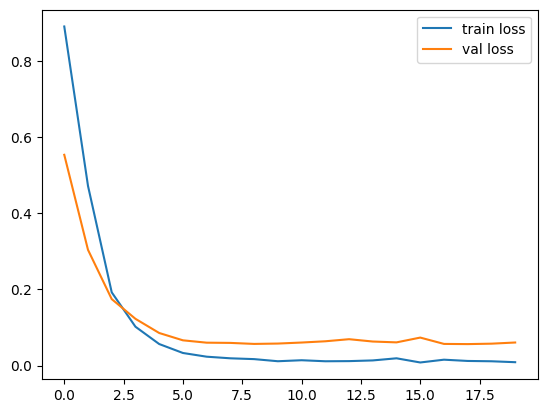

In [25]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

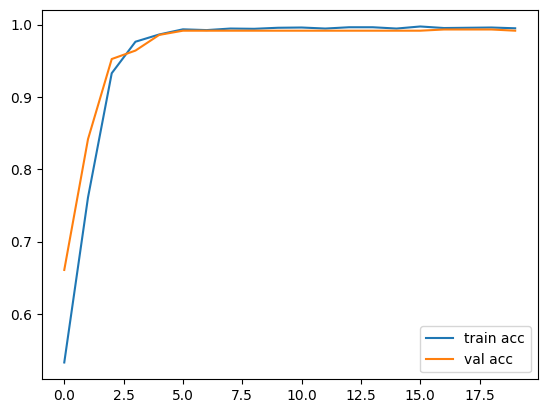

In [26]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

In [27]:

from sklearn.metrics import classification_report

predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)
y_true = df_test['targets']
report = classification_report(y_true, y_pred)
print(report)

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       417
           1       1.00      1.00      1.00       364
           2       0.98      0.99      0.99       419

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [28]:
classes = df['targets'].unique()

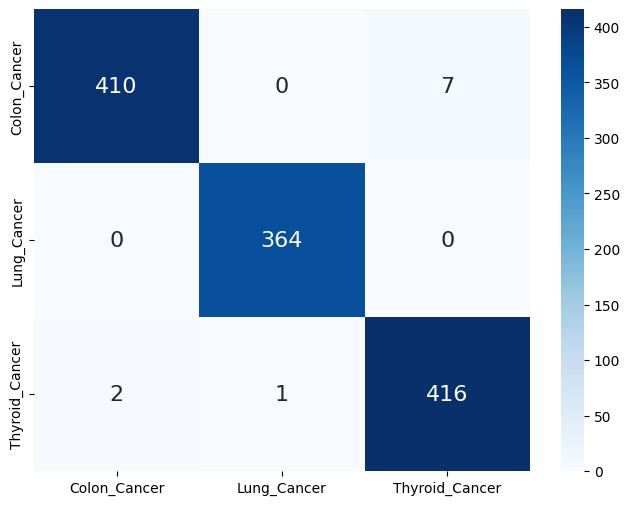

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_mapping = {
    0: 'Colon_Cancer',
    1: 'Lung_Cancer',
    2: 'Thyroid_Cancer'
    
}
marks = np.arange(len(label_mapping))

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[label_mapping[i] for i in label_mapping] , columns = [label_mapping[i] for i in label_mapping])
plt.figure(figsize=(8, 6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')
plt.show()

In [30]:
i = Input(shape=(T,))
x = Embedding(V+1,D)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(K)(x)
model = Model(i,x)

In [32]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)
print('Training model...')
r_rnn = model.fit(
  data_train,
  df_train['targets'],
  epochs=5,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5732 - loss: 0.8902 - val_accuracy: 0.8050 - val_loss: 0.5315
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.7806 - loss: 0.5281 - val_accuracy: 0.8517 - val_loss: 0.3636
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.8981 - loss: 0.3198 - val_accuracy: 0.9142 - val_loss: 0.2699
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9479 - loss: 0.2206 - val_accuracy: 0.9317 - val_loss: 0.1961
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.9439 - loss: 0.1969 - val_accuracy: 0.9492 - val_loss: 0.1550


In [33]:
predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)
y_true = df_test['targets']
report = classification_report(y_true, y_pred)
print(report)

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       417
           1       1.00      1.00      1.00       364
           2       0.89      0.97      0.93       419

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



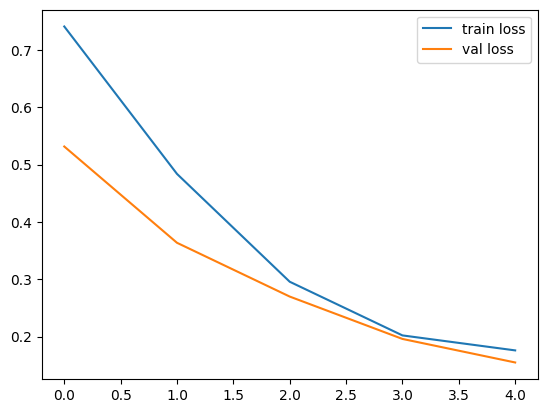

In [34]:
plt.plot(r_rnn.history['loss'], label='train loss')
plt.plot(r_rnn.history['val_loss'], label='val loss')
plt.legend()

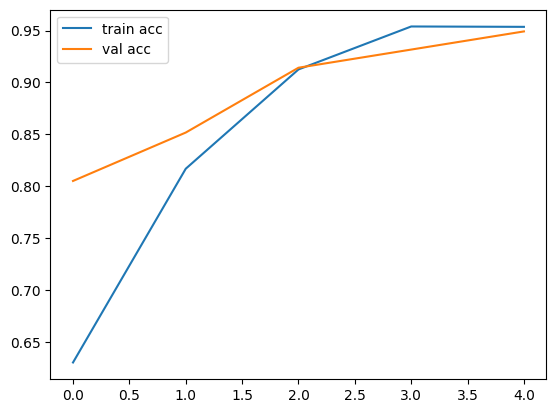

In [35]:
plt.plot(r_rnn.history['accuracy'], label='train acc')
plt.plot(r_rnn.history['val_accuracy'], label='val acc')
plt.legend()

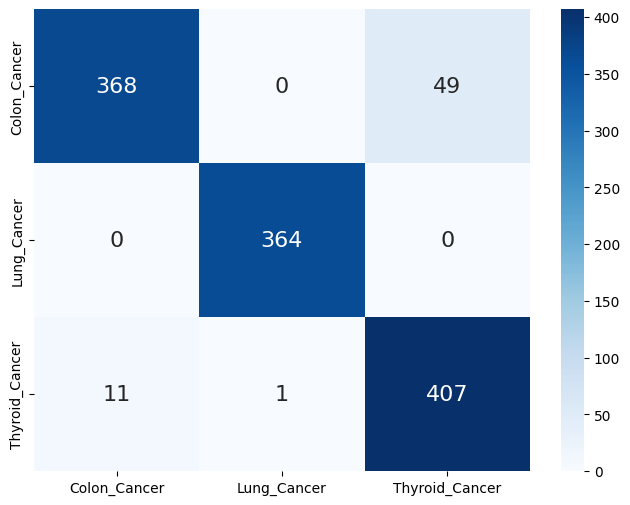

In [36]:
label_mapping = {
    0: 'Colon_Cancer',
    1: 'Lung_Cancer',
    2: 'Thyroid_Cancer'
    
}
marks = np.arange(len(label_mapping))
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[label_mapping[i] for i in label_mapping] , columns = [label_mapping[i] for i in label_mapping])
plt.figure(figsize=(8, 6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')
plt.show()